In [1]:
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk import accuracy
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import dtype
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer,BaseNetwork,TrainLastLayerCL, PredLastLayerCl
from baseNN import GetNeuralNetwork, PredNormal, TrainNN, GetNeuralNetworkClassification, TrainNNClass, PredictClass

Loading Dataset

In [2]:
np.random.seed(123)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [5]:
# load dataset, medical, diabetes, relevant. Diagnosis
df = pd.read_csv("/Users/kingmopser/PycharmProjects/ProbabilisticML/Dataset of Diabetes .csv")
df.drop(columns=["ID","No_Pation"], inplace=True)
len(df.columns) # 13

12

Pre-Processing for Input Data

In [6]:
scaler = StandardScaler()
encoder =LabelEncoder()
df["Gender"] = df["Gender"].apply(lambda x: 1 if x=="M" else 0)
c = df.columns[1:len(df.columns)-1]
df[c] =scaler.fit_transform(df[c])
df["CLASS"] = df["CLASS"].apply(lambda x: "N" if re.match(r"N",x) else "P" if x=="P" else "Y" if re.match(r"Y",x) else 0)
df["CLASS"]= pd.Categorical(df["CLASS"], categories=["N","P","Y"], ordered=True)
df["CLASS"] = encoder.fit_transform(df["CLASS"])

In [7]:
X = df.iloc[:,:-1].to_numpy(dtype=np.float32)
y= df['CLASS'].to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8)
tenX = torch.tensor(X_train).to(device)
tenY = torch.tensor(y_train).to(device)
tenXTest = torch.tensor(X_test).to(device)
tenYTest = torch.tensor(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)
trainLoader = DataLoader(tenDF,batch_size=32,shuffle=True)

Creating OOD samples


In [22]:
# Feature-Namen ohne Gender
feature_names = df.columns[1:len(df.columns)-1]
# Wähle beliebige Werte außerhalb des Trainingsbereichs, z. B. +5 und -5 Standardabweichungen
n_ood = 50  # wie viele OOD-Beispiele pro Feature

ood_samples = []
for i, feature in enumerate(feature_names):
    # Template: Mittelwert aller Features (z. B. aus X_train)
    base = np.mean(X_train, axis=0)
    # Für dieses Feature Wert weit außerhalb setzen (+5)
    ood_high = base.copy()
    ood_high[i] = 4  # oder beliebig >3

    ood_low = base.copy()
    ood_low[i] = -4  # oder beliebig <-3

    ood_samples.append(ood_high)
    ood_samples.append(ood_low)

# Zu Array zusammenfügen
X_ood = np.stack(ood_samples)
X_ood = np.column_stack((np.zeros(len(X_ood)),X_ood[:,:-1]))
y_ood = np.zeros(len(X_ood))
# Dummy, wenn Label nötig, ansonsten ignorieren
X_test_ODD= np.vstack([X_test,X_ood])
y_test_OOD=np.concatenate([y_test, y_ood])
# Zu Tensor (optional)
tenX_OOD = torch.tensor(X_test_ODD, dtype=torch.float32).to(device)
tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)
#MASK
is_ood = np.array([False]*len(X_test) + [True]*len(X_ood))
X_test_ODD

array([[ 0.00000000e+00, -2.67520499e+00,  1.96086004e-01, ...,
         6.19275630e-01, -3.15339565e-01, -1.52785552e+00],
       [ 1.00000000e+00, -1.31076849e+00, -1.78867459e-01, ...,
         1.06788957e+00, -2.60721117e-01, -1.52785552e+00],
       [ 1.00000000e+00, -1.08336246e+00, -6.90167606e-01, ...,
         1.70661718e-01, -2.88030326e-01, -1.12462211e+00],
       ...,
       [ 0.00000000e+00,  5.63750029e-01, -3.75220715e-03, ...,
         1.13619317e-03, -4.00000000e+00,  1.85497459e-02],
       [ 0.00000000e+00,  5.63750029e-01, -3.75220715e-03, ...,
         1.13619317e-03,  7.37972325e-04,  4.00000000e+00],
       [ 0.00000000e+00,  5.63750029e-01, -3.75220715e-03, ...,
         1.13619317e-03,  7.37972325e-04, -4.00000000e+00]])

In [8]:
base = np.mean(X_train, axis=0)  # shape: (n_feats+1,), falls die erste Spalte evtl. Label/Index war
n_ood = 30
ood_samples = []
for _ in range(n_ood):
    # Erzeuge Vektor, bei dem alle Features +4 bekommen
    ood_high_all = base.copy()
    # Index 0 überspringen wir später ohnehin (ist evtl. das Label oder konstante Spalte)
    ood_high_all[1:-1] = np.random.choice([np.random.uniform(8,10),np.random.uniform(-4,-8) ], size=9)  # alle Feature-Spalten auf +4 setzen

    # Erzeuge Vektor, bei dem alle Features -4 bekommen
  #  ood_low_all = base.copy()
 #   ood_low_all[1:-1] = -4  # alle Feature-Spalten auf -4 setzen

    ood_samples.append(ood_high_all)
#    ood_samples.append(ood_low_all)

# Aus Liste ein Array machen
X_ood = np.stack(ood_samples)  # shape: (2*n_ood, n_feats+1)

# Wenn du in deinem Setting die erste Spalte hart auf 0 setzen willst
# (wie in deinem Original: np.zeros + Spalten verschieben), dann:
X_ood = np.column_stack((np.zeros(len(X_ood)), X_ood[:, 1:]))  # erste Spalte 0, Rest Features

# Dummy-Labels (falls nötig)
y_ood = np.zeros(len(X_ood))

# Zusammensetzen mit echtem Test-Set
X_test_OOD = np.vstack([X_test, X_ood])
y_test_OOD = np.concatenate([y_test, y_ood])

tenX_OOD = torch.tensor(X_test_OOD, dtype=torch.float32).to(device)
tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)


is_ood = np.array([False] * len(X_test) + [True] * len(X_ood))


MAP Model fitting

In [9]:
# BASE NN CLASSIFIER
nn = GetNeuralNetworkClassification(len(df.columns[:-1]),len(np.unique(y)))
TrainNNClass(nn,trainLoader,epochs=100)
prob,mapentr = PredictClass(nn,tenX_OOD)

Epoch: 0 | Loss: 0.75231
Epoch: 10 | Loss: 0.14450
Epoch: 20 | Loss: 0.13595
Epoch: 30 | Loss: 0.18551
Epoch: 40 | Loss: 0.13799
Epoch: 50 | Loss: 0.16673
Epoch: 60 | Loss: 0.21423
Epoch: 70 | Loss: 0.10990
Epoch: 80 | Loss: 0.12225
Epoch: 90 | Loss: 0.03124


Bayesian LL Classifier fitting


In [10]:
# bayesian
base = BaseNetwork(len(df.columns[:-1])).to(device)
head = torch.nn.Linear(in_features=8,out_features=len(df["CLASS"].unique())).to(device)
baseMod = torch.nn.Sequential(base,head)
TrainNNClass(baseMod,trainLoader,100)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
lastLayer = BayesianLastLayer(in_features=8,out_features=len(df["CLASS"].unique())).to(device)
TrainLastLayerCL(base,lastLayer,trainLoader,epochs=100)
mean_prob, entropy,exp_entr ,mi = PredLastLayerCl(base,lastLayer,tenX_OOD)

Epoch: 0 | Loss: 0.95885
Epoch: 10 | Loss: 0.19688
Epoch: 20 | Loss: 0.28641
Epoch: 30 | Loss: 0.20210
Epoch: 40 | Loss: 0.06178
Epoch: 50 | Loss: 0.17419
Epoch: 60 | Loss: 0.11383
Epoch: 70 | Loss: 0.20589
Epoch: 80 | Loss: 0.12543
Epoch: 90 | Loss: 0.21855


In [11]:
#MAP
#ID
prob_ID = prob[~is_ood]
mapentr_ID = mapentr[~is_ood]
#OOD
prob_OOD =prob[is_ood]
mapentr_OOD = mapentr[is_ood]



#BAYES
#ID
mean_prob_ID= mean_prob[~is_ood]
pred_ent_ID = entropy[~is_ood]
aleatoric_ID = exp_entr[~is_ood]
epistemic_ID = mi[~is_ood]
#OOD
mean_prob_OOD= mean_prob[is_ood]
pred_ent_OOD = entropy[is_ood]
aleatoric_OOD = exp_entr[is_ood]
epistemic_OOD = mi[is_ood]

PLOTS

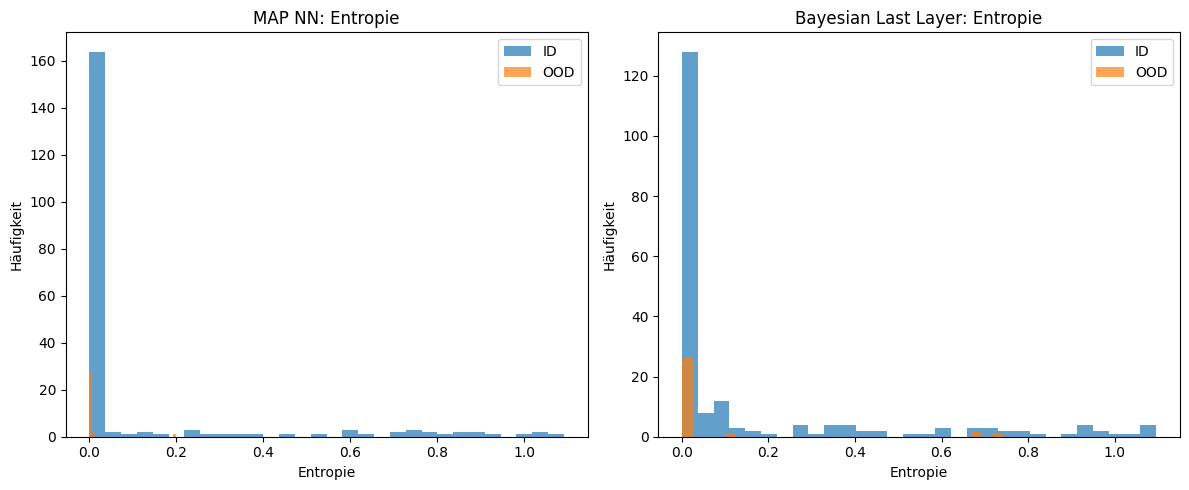

In [12]:
plt.figure(figsize=(12,5))
#MAP ENTROPY
plt.subplot(1,2,1)
plt.hist(mapentr_ID, bins=30, alpha=0.7, label='ID')
plt.hist(mapentr_OOD, bins=30, alpha=0.7, label='OOD')
plt.title('MAP NN: Entropie')
plt.xlabel('Entropie')
plt.ylabel('Häufigkeit')
plt.legend()
# BLL ENTROPY
plt.subplot(1,2,2)
plt.hist(pred_ent_ID, bins=30, alpha=0.7, label='ID')
plt.hist(pred_ent_OOD, bins=30, alpha=0.7, label='OOD')
plt.title('Bayesian Last Layer: Entropie')
plt.xlabel('Entropie')
plt.ylabel('Häufigkeit')
plt.legend()

plt.tight_layout()
plt.show()
